In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

from sklearn.mixture import GaussianMixture

In [2]:
from torch_geometric.loader import DataLoader
import umap

In [3]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [4]:
import configuration
import model_registry
import data.construct
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions, get_distribution_labels
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model


In [8]:
density_model_nfpc = get_density_model(
                            density_type='GaussianMixture',
                            number_components = -1
)
density_model_nfpc.evaluation_kwargs

[('', {})]

In [5]:
cpkt_path = '/nfs/students/fuchsgru/model_registry/735717837.ckpt'
registry = model_registry.ModelRegistry()
# Find a cnfg for that checkpoint
for cfg, path in registry.items():
    if path == cpkt_path:
        break
else:
    raise RuntimeError(f'Could not find a configuration for {cpkt_path}')

In [6]:
config = configuration.get_experiment_configuration(cfg)
config['data']['num_dataset_splits'] = 1

In [7]:
data_list, fixed_vertices = data.construct.load_data_from_configuration(config['data'])
        

In [8]:
data_dict = data_list[config['split_idx']]
data_loaders = {
        name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

In [9]:
model = SemiSupervisedNodeClassification(
        config['model'], 
        data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
        data_get_num_classes(data_dict[dconst.TRAIN][0]), 
        learning_rate=config['training']['learning_rate'],
        self_loop_fill_value=config['model']['self_loop_fill_value'],
    )

In [10]:
reg = model_registry.ModelRegistry()

In [11]:
idx_to_label = {idx : label for label, idx in data_dict[dconst.TRAIN][0].label_to_idx.items()}

In [12]:
ckpt_path = reg[config]
if not ckpt_path:
    raise RuntimeError(f'No model checkpoint found!')

In [13]:
model = model.load_from_checkpoint(ckpt_path, strict=False)
_ = model.eval()

In [14]:
with torch.no_grad():
    features, predictions, labels, mask, logits = [torch.cat(x, 0) for x in run_model_on_datasets(
        model, [data_loaders[dconst.VAL]], gpus=0, model_kwargs={},
        callbacks = [
            ecbs.make_callback_get_features(mask = False),
            ecbs.make_callback_get_predictions(mask = False),
            ecbs.make_callback_get_ground_truth(mask = False),
            ecbs.make_callback_get_mask(mask = False),
            ecbs.make_callback_get_logits(mask = False),
        ]
    )]
    
    mask_train, = [torch.cat(x, 0) for x in run_model_on_datasets(
        model, [data_loaders[dconst.TRAIN]], gpus=0, model_kwargs={}, run_model=False,
        callbacks = [
            ecbs.make_callback_get_mask(mask = False),
        ]
    )]
    

In [15]:
predictions_train_orig = predictions.clone()
predictions[mask_train] = label_binarize(labels[mask_train], num_classes=predictions.size(1)).float()
gnd_binarized = label_binarize(labels).float()[:, :predictions.size(1)]

In [16]:
proj = umap.UMAP(random_state = 1337)
_ = proj.fit(features.cpu().numpy())


In [17]:
features_proj = proj.transform(features.cpu().numpy())

In [18]:
density_model_nfpc = get_density_model(
                            density_type='NormalizingFlow', 
                            flow_type = 'maf',
                            num_layers = 10,
                            hidden_dim = features.size(1),
                            num_hidden = 2,
                            gpu = True,
                            verbose=True,
                            iterations='auto',
                            #mode='weighted',
                            weight_decay=1e-1,
)
density_model_nfpc.fit(features[mask_train], (predictions * label_binarize(predictions.argmax(1)))[mask_train])

Fit normalizing flow with GPU acceleration.


100%|██████████| 280/280 [00:05<00:00, 50.70it/s]


In [19]:
density_model_nfpc.evaluation_kwargs

In [9]:
for k, v in {'val_loss-val-0': [0.5964447259902954, 0.5995340347290039, 0.5516130328178406, 0.5587871074676514], 'val_accuracy-val-0': [0.8571428656578064, 0.8714285492897034, 0.8714285492897034, 0.8500000238418579], 'auroc_gpc-diag-mode:max-relative:True:no': [0.7445143387196096, 0.7660126745083367, 0.8160475226630548, 0.7903534269785468], 'aucpr_gpc-diag-mode:max-relative:True:no': [0.6294085453833342, 0.6236875110636596, 0.7142758699026167, 0.6511158351401463], 'auroc_gpc-diag-mode:max-relative:False:no': [0.7225197275942079, 0.7472607420225689, 0.7899983259523049, 0.7689611265833701], 'aucpr_gpc-diag-mode:max-relative:False:no': [0.6027363529786272, 0.6018329381500267, 0.6813810600945791, 0.6241785404131625], 'auroc_gpc-diag-mode:weighted-relative:True:no': [0.7456887704064001, 0.7668467288699733, 0.8171914552547342, 0.7912919082621863], 'aucpr_gpc-diag-mode:weighted-relative:True:no': [0.6305686199494174, 0.6247102599794373, 0.7158091776932105, 0.6529466836309413], 'auroc_gpc-diag-mode:weighted-relative:False:no': [0.7237227405831105, 0.748183138590734, 0.7912893718262846, 0.7699351179696338], 'aucpr_gpc-diag-mode:weighted-relative:False:no': [0.6040173672370254, 0.6026605138902612, 0.6834702151016603, 0.6258753700691896], 'auroc_gpc-full-mode:max-relative:True:no': [0.7746572192471686, 0.685165264883713, 0.7877256793843563, 0.6495254328427866], 'aucpr_gpc-full-mode:max-relative:True:no': [0.5948460602768312, 0.46263578819599266, 0.585544635040017, 0.44609521503355837],'auroc_gpc-full-mode:max-relative:False:no': [0.688601516887652, 0.5988406384543232, 0.658139169165056, 0.5330801970303408], 'aucpr_gpc-full-mode:max-relative:False:no': [0.5213751860056249, 0.3762435866692335, 0.4312924829448789, 0.3134191983038894], 'auroc_gpc-full-mode:weighted-relative:True:no': [0.7745662787404479, 0.6816380723730536, 0.7859476378172447, 0.6513491302561293], 'aucpr_gpc-full-mode:weighted-relative:True:no': [0.5963312112377769, 0.45893815397456755, 0.5835742468197042, 0.4502543969887126], 'auroc_gpc-full-mode:weighted-relative:False:no': [0.6887262352968688, 0.5951666419828148, 0.6559223241869455, 0.5352564590340237], 'aucpr_gpc-full-mode:weighted-relative:False:no': [0.5237324208595927, 0.37256373723364544, 0.4259644106911118, 0.31754454817710603], 'auroc_nfpc-2-maf-2-None-mode:max-relative:True:no': [0.47156550184869056, 0.5131019287182326, 0.5677215703581955, 0.5488441461595824], 'aucpr_nfpc-2-maf-2-None-mode:max-relative:True:no': [0.1847716402220268, 0.23684988305471322, 0.2557563271709896, 0.2386336932067255], 'auroc_nfpc-2-maf-2-None-mode:max-relative:False:no': [0.262469892196525, 0.24771154710588333, 0.25196954247769204, 0.25327834340298383], 'aucpr_nfpc-2-maf-2-None-mode:max-relative:False:no': [0.1767827916814604, 0.17352690264545412, 0.15376573107181246, 0.13421112049072037], 'auroc_nfpc-2-maf-2-None-mode:weighted-relative:True:no': [0.46969732401063224, 0.5107582619450356, 0.5659447970090348, 0.5459399270521035], 'aucpr_nfpc-2-maf-2-None-mode:weighted-relative:True:no': [0.18418097550011056, 0.23585526514461883, 0.2548262321160234, 0.237721734180958],'auroc_nfpc-2-maf-2-None-mode:weighted-relative:False:no': [0.26088752737958826, 0.24545882083940687, 0.2490906877292304, 0.24732025546982403], 'aucpr_nfpc-2-maf-2-None-mode:weighted-relative:False:no': [0.176590270493061, 0.17299549220752153, 0.15327094758779708, 0.13315288954361265], 'auroc_nf-2-maf-2-64:no': [0.5766368641634643, 0.5109635276602047, 0.2630689859836552, 0.44003865528314234], 'aucpr_nf-2-maf-2-64:no': [0.26026907931556975, 0.17056855874159338, 0.11651512918713122, 0.15951892907062498], 'auroc_mog-7-diag-random:no': [0.6331875686925613, 0.5532118887823586, 0.6108371760337244, 0.542312823712632], 'aucpr_mog-7-diag-random:no': [0.34944617650599513, 0.2623208530207428, 0.3082039059570424, 0.23215835912318328], 'auroc_mog-7-diag-predictions:no': [0.6345360864922169, 0.5543369527655009, 0.6172264580701781, 0.5422392670714818], 'aucpr_mog-7-diag-predictions:no': [0.35593023550244696, 0.263184326791734, 0.3294573842034859, 0.2370331583789829], 'auroc_mog-7-full-random:no': [0.3311819407743454, 0.35268547316345644, 0.3373206105708503, 0.455176104744657], 'aucpr_mog-7-full-random:no': [0.13000352215338504, 0.12965607909168267, 0.12848935787088164, 0.17106547374747366], 'auroc_mog-7-full-predictions:no': [0.3346844494331808, 0.37053059888221124, 0.32688824970704167, 0.4494361502990458], 'aucpr_mog-7-full-predictions:no': [0.13225477008938624, 0.13209759328688542, 0.12625811063869374, 0.1717531582749228], 'auroc_total-predictive-entropy': [0.9047099387580645, 0.9002018879249194, 0.9078107007157822, 0.9026693451429788], 'aucpr_total-predictive-entropy': [0.7143863268364443, 0.7066120416406707, 0.7569427912961861, 0.740886529977546], 'auroc_max-score': [0.8895488571376605, 0.8846666510768655, 0.9065399463290162, 0.8944310013341653], 'aucpr_max-score': [0.7016936406236886, 0.693926580818462, 0.7544897725143773, 0.7308264777620694]}.items():
    print(k, f'{np.mean(v):.2f}, {np.std(v):.2f}')

val_loss-val-0 0.58, 0.02
val_accuracy-val-0 0.86, 0.01
auroc_gpc-diag-mode:max-relative:True:no 0.78, 0.03
aucpr_gpc-diag-mode:max-relative:True:no 0.65, 0.04
auroc_gpc-diag-mode:max-relative:False:no 0.76, 0.03
aucpr_gpc-diag-mode:max-relative:False:no 0.63, 0.03
auroc_gpc-diag-mode:weighted-relative:True:no 0.78, 0.03
aucpr_gpc-diag-mode:weighted-relative:True:no 0.66, 0.04
auroc_gpc-diag-mode:weighted-relative:False:no 0.76, 0.03
aucpr_gpc-diag-mode:weighted-relative:False:no 0.63, 0.03
auroc_gpc-full-mode:max-relative:True:no 0.72, 0.06
aucpr_gpc-full-mode:max-relative:True:no 0.52, 0.07
auroc_gpc-full-mode:max-relative:False:no 0.62, 0.06
aucpr_gpc-full-mode:max-relative:False:no 0.41, 0.08
auroc_gpc-full-mode:weighted-relative:True:no 0.72, 0.06
aucpr_gpc-full-mode:weighted-relative:True:no 0.52, 0.07
auroc_gpc-full-mode:weighted-relative:False:no 0.62, 0.06
aucpr_gpc-full-mode:weighted-relative:False:no 0.41, 0.08
auroc_nfpc-2-maf-2-None-mode:max-relative:True:no 0.53, 0.04
auc

In [36]:
print(str(density_model_nfpc))

NormalizingFlow
	Flow type : maf
	Number of layers : 10
	Hidden dimensionality : 64
	Number of hidden units per layer : 2 	Iterations : auto
	Weight Decay : 0.1	 On GPU : True


AttributeError: 'FeatureSpaceDensityNormalizingFlow' object has no attribute 'get_density_class'

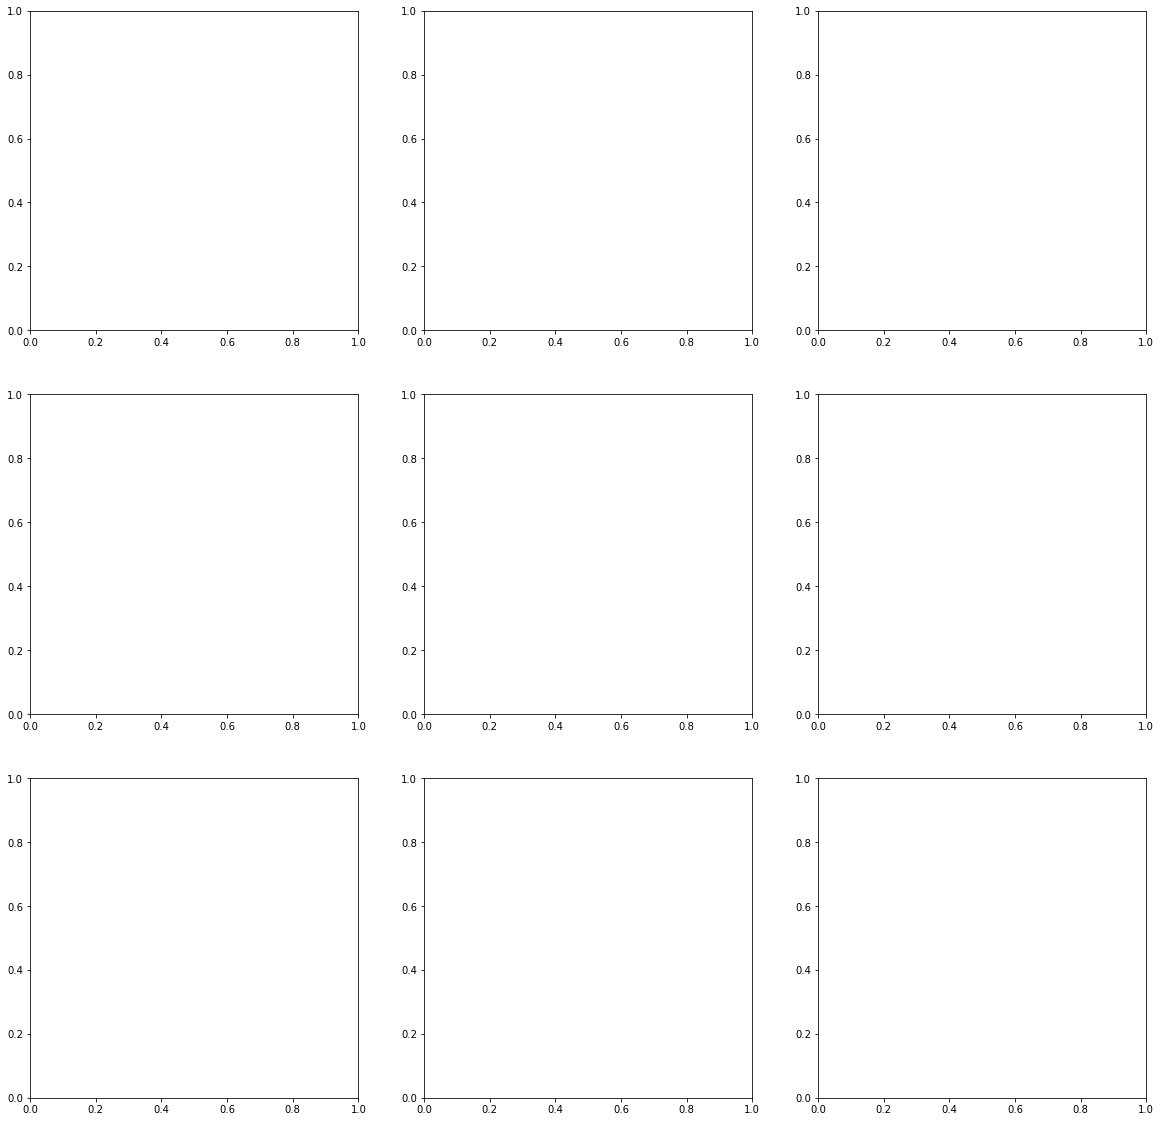

In [31]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_nfpc.get_density_class(class_label, features)[~mask_train], vmin=-50)
    ax.scatter(
        features_proj[:, 0][(mask_train) & (labels == class_label)], 
        features_proj[:, 1][(mask_train) & (labels == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    #mean_proj = proj.transform(density_model_nfpc.means[class_label][None, :].cpu())
    #ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    real_mean_proj = proj.transform(features[(mask_train) & (labels == class_label)].mean(0, keepdim=True).numpy())
    ax.scatter(real_mean_proj[:, 0], real_mean_proj[:, 1], s=200, marker='+', color='red', label='Train Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])

In [25]:
from model.normalizing_flow import NormalizingFlow
import pyblaze.nn as xnn
from tqdm import tqdm

flow = NormalizingFlow('maf', 2, features.size(1), hidden_dim=features.size(1))
flow.xflow.train()
loss_fn = xnn.TransformedNormalLoss(reduction='none')
optimizer = torch.optim.Adam(flow.xflow.parameters(), lr=1e-3, weight_decay=1e-0) 

x = features[(labels == 0) & mask_train].cuda()
mask_fval = ~((labels == 0) & (mask_train))
x_val = features[mask_fval].cuda()

weights = predictions[(labels == 0) & mask_train][:, 0].cuda()
#weights_val = (1 - predictions[~mask_train | (mask_train & (labels != 0))][:, 0]).cuda()
weights_val = predictions[mask_fval][:, 0].cuda()


flow.xflow = flow.xflow.cuda()
losses, losses_val = [], []
for _ in tqdm(range(200)):
    flow.xflow.train()
    optimizer.zero_grad()
    loss = loss_fn(*flow.xflow(x))
    loss *= weights
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    with torch.no_grad():
        flow.xflow.eval()
        loss_val = loss_fn(*flow.xflow(x_val))
        loss_val *= weights_val
        losses_val.append(loss_val.mean().item())
        
    
    

100%|██████████| 200/200 [00:01<00:00, 187.23it/s]


In [26]:
x_val.size()

torch.Size([2423, 64])

Text(0, 0.5, 'NLL')

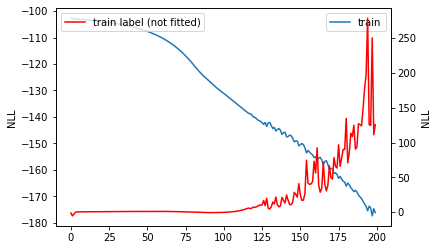

In [27]:
fig, ax = plt.subplots()

ax.plot(range(len(losses)), losses, label='train')
ax2 = plt.twinx(ax)
ax2.plot(range(len(losses)), losses_val, label='train label (not fitted)', color='red')
ax.legend()
ax.set_ylabel('NLL')
ax2.legend()
ax2.set_ylabel('NLL')


In [30]:
density_model_gmm = get_density_model(
                            density_type='GaussianMixture', 
                            diagonal_covariance=True,
                            number_components = predictions.size(1),
                            initialization = 'predictions',
)
density_model_gmm.fit(features, predictions)

Initialization 0
  Iteration 10
Initialization converged: True


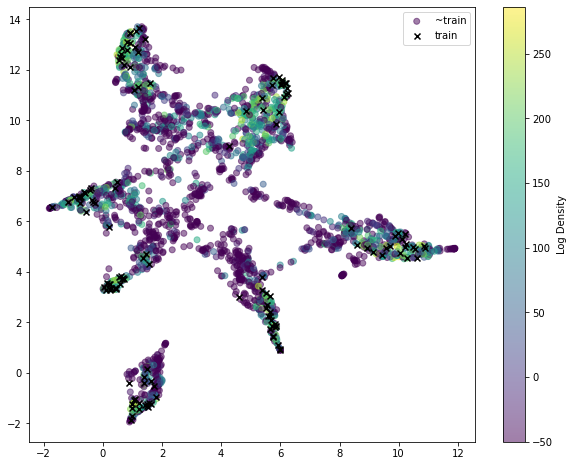

In [32]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_nfpc(features)[~mask_train], vmin=-50)
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Log Density')
plt.legend()

In [60]:
density_model = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
density_model.fit(features[mask_train], predictions[mask_train])

density_model_max = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
                            mode='max'
)
density_model_max.fit(features[mask_train], predictions[mask_train])


density_model_all_graph = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
density_model_all_graph.fit(features, predictions)

density_model_all_graph_best_prediction = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
density_model_all_graph_best_prediction.fit(features, predictions * label_binarize(predictions.argmax(1)))


density_model_all_graph_best_prediction_99conf = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)

predictions99conf = predictions * label_binarize(predictions.argmax(1))
predictions99conf[predictions99conf < .99] = 0.0
density_model_all_graph_best_prediction_99conf.fit(features, predictions99conf)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


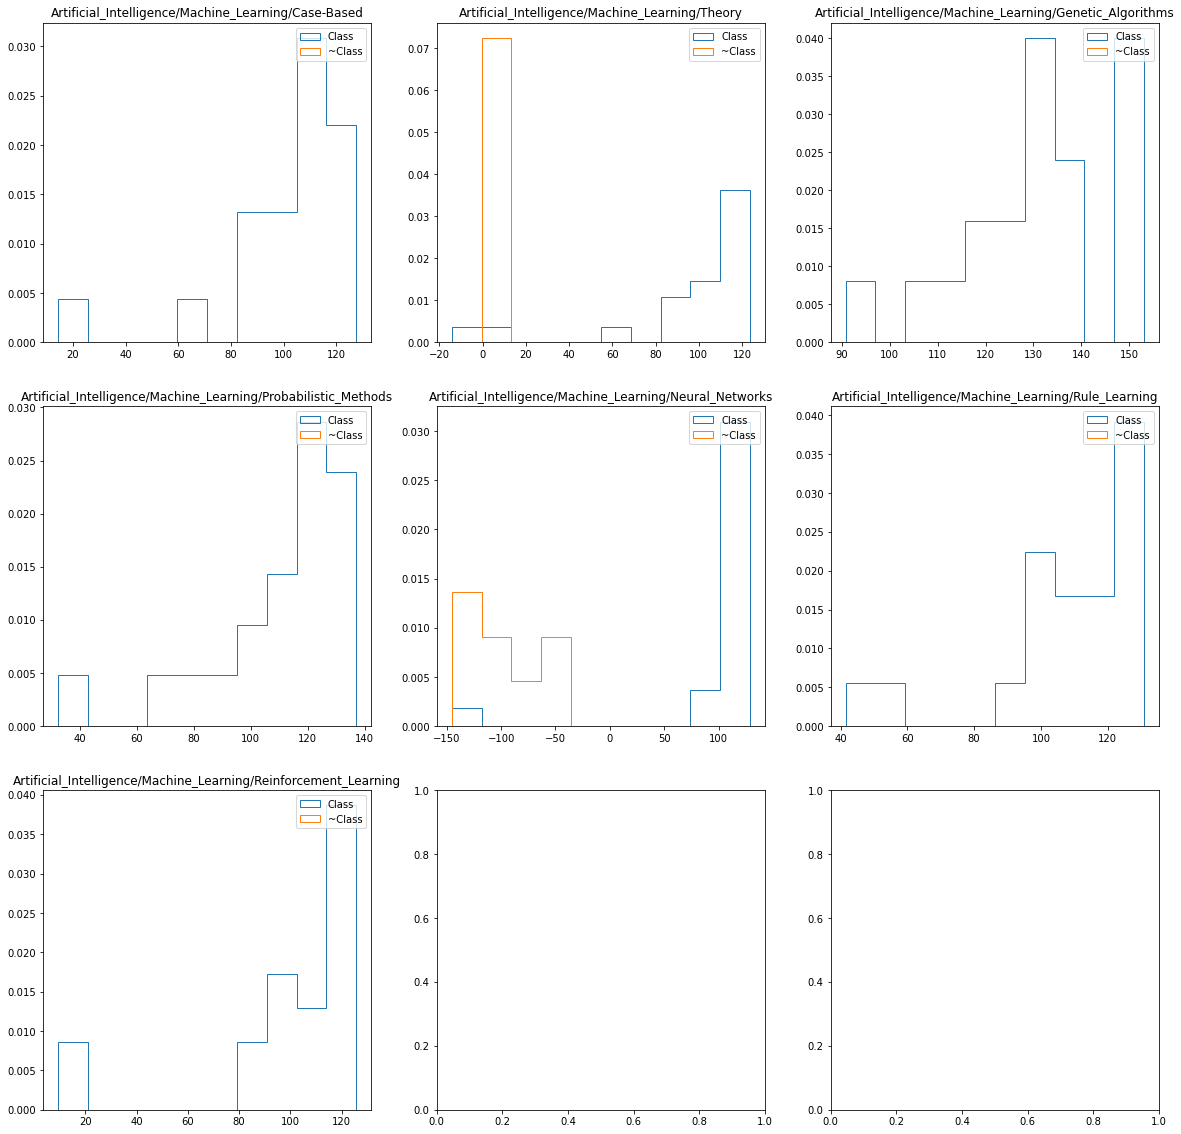

In [44]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    dc0 = density_model.get_density_class(class_label, features)
    _, bins, _ = ax.hist(dc0[(labels == class_label) & (mask_train)].numpy(), histtype=u'step', density=True, label='Class')
    ax.hist(dc0[(labels != class_label)  & (mask_train)].numpy(), bins=bins, histtype=u'step', density=True, label='~Class')
    ax.set_title(idx_to_label[class_label])
    ax.legend()

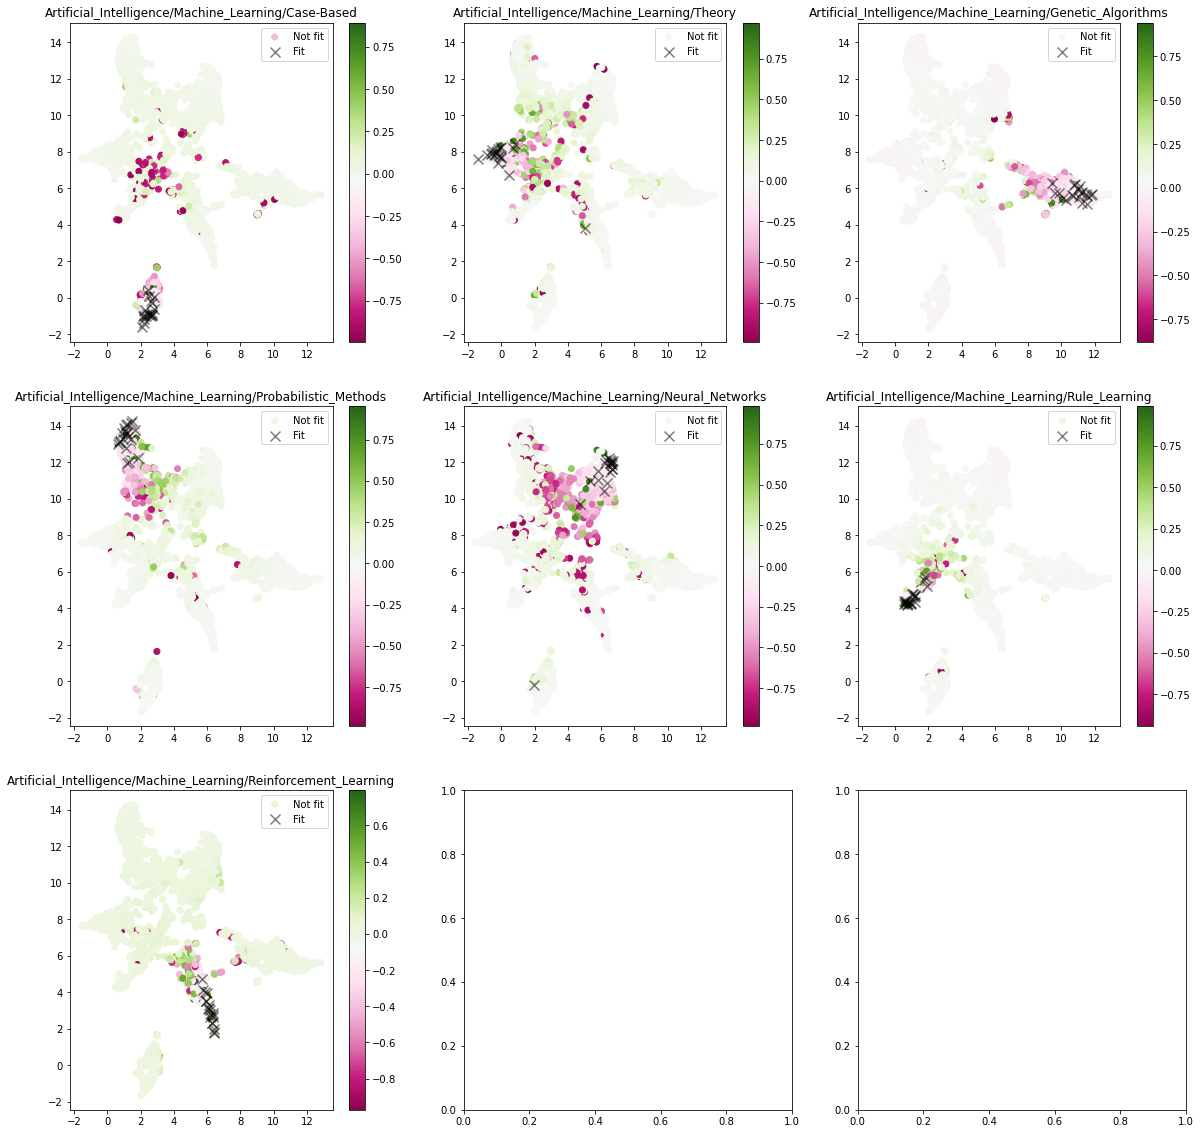

In [47]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    is_fitted = mask_train & (labels == class_label)
    
    scatter = ax.scatter(features_proj[:, 0][~is_fitted], features_proj[:, 1][~is_fitted], 
                         c = (predictions - gnd_binarized)[:, class_label][~is_fitted], cmap = 'PiYG', label='Not fit', marker='o')
    _ = ax.scatter(features_proj[:, 0][is_fitted], features_proj[:, 1][is_fitted], 
                         color='black', label='Fit', marker='x', s=100, alpha=0.5)
    ax.legend()
    
    
    ax.set_title(idx_to_label[class_label])
    plt.colorbar(scatter, ax=ax)

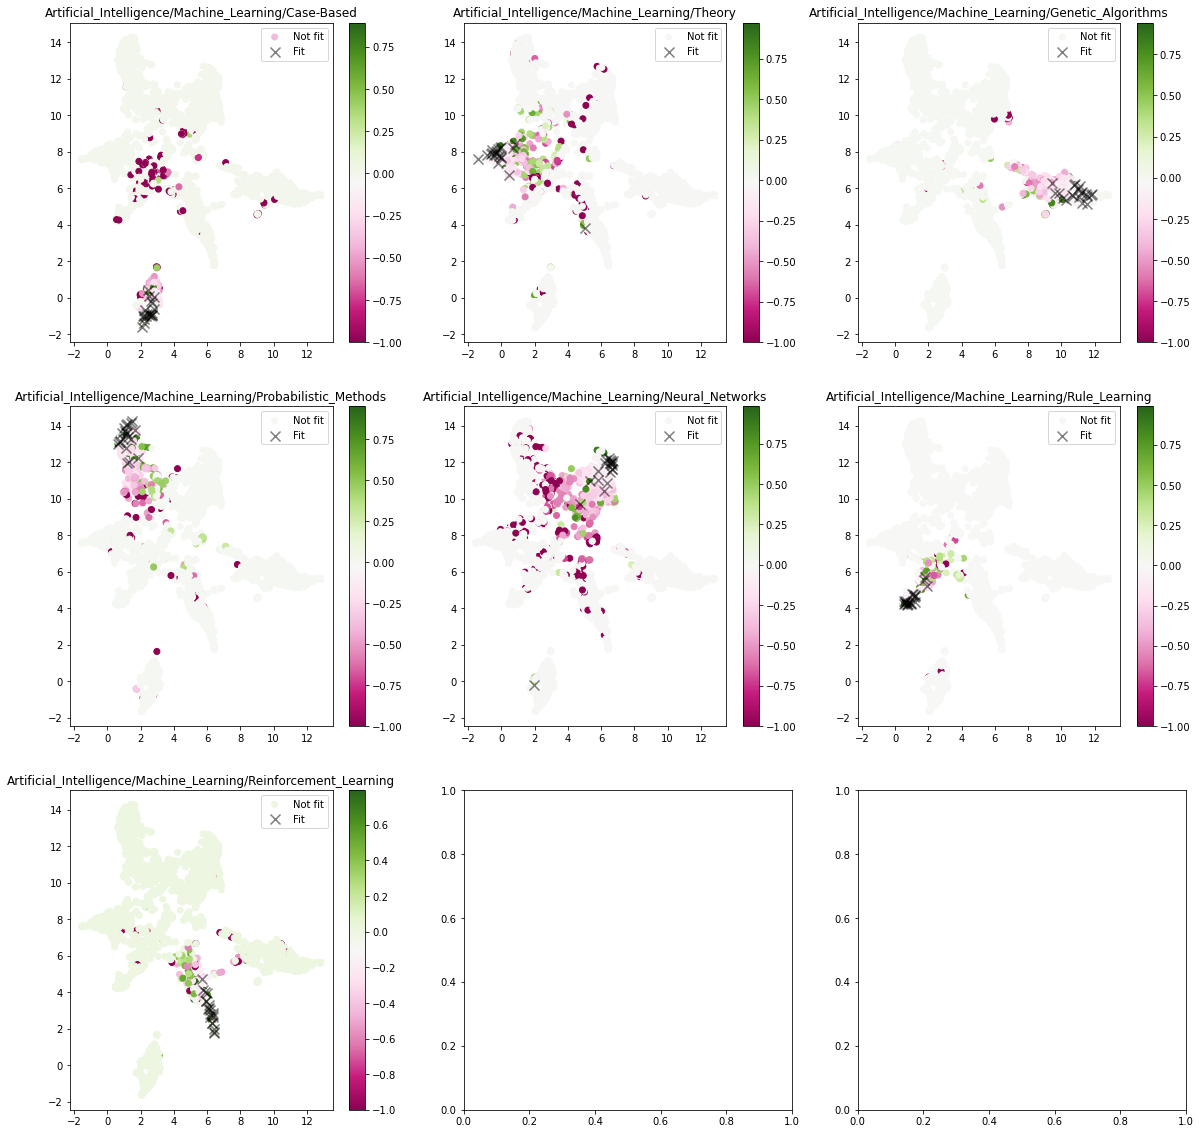

In [48]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    is_fitted = mask_train & (labels == class_label)
    
    scatter = ax.scatter(features_proj[:, 0][~is_fitted], features_proj[:, 1][~is_fitted], 
                         c = ((predictions * label_binarize(predictions.argmax(1))) - gnd_binarized)[:, class_label][~is_fitted], cmap = 'PiYG', label='Not fit', marker='o')
    _ = ax.scatter(features_proj[:, 0][is_fitted], features_proj[:, 1][is_fitted], 
                         color='black', label='Fit', marker='x', s=100, alpha=0.5)
    ax.legend()
    
    
    ax.set_title(idx_to_label[class_label])
    plt.colorbar(scatter, ax=ax)

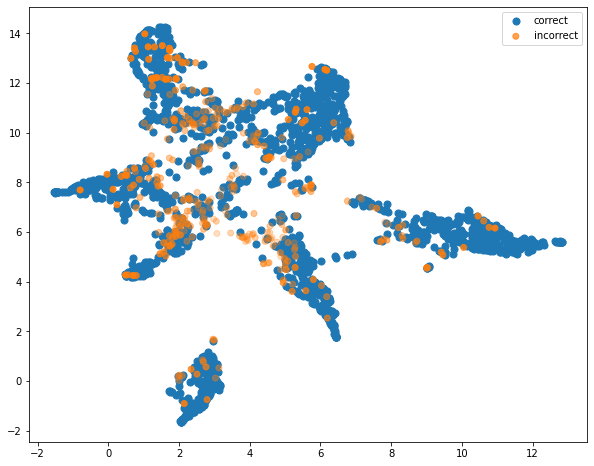

In [34]:
fig = plt.figure(figsize=(10, 8))
correct = labels == predictions.argmax(1)
conf = predictions.max(1)[0]
plt.scatter(features_proj[:, 0][correct], features_proj[:, 1][correct], label='correct', s=50)
plt.scatter(features_proj[:, 0][~correct], features_proj[:, 1][~correct], label='incorrect', alpha = conf[~correct])
plt.legend()

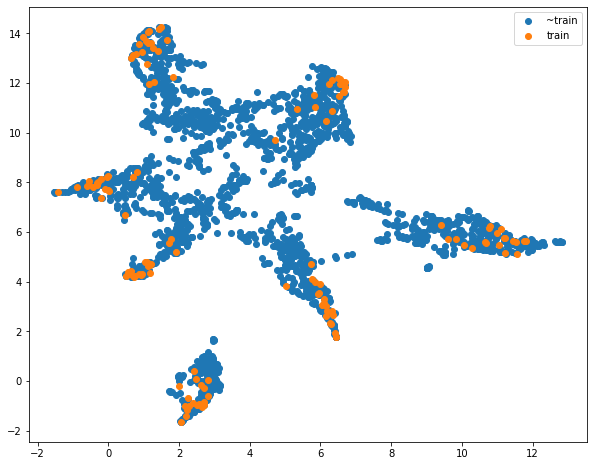

In [35]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], label='~train')
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train')
plt.legend()

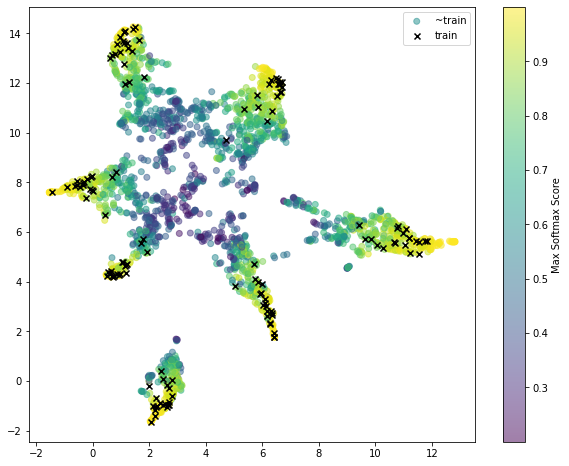

In [49]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', c=predictions.max(1)[0].numpy()[~mask_train])
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Max Softmax Score')
plt.legend()

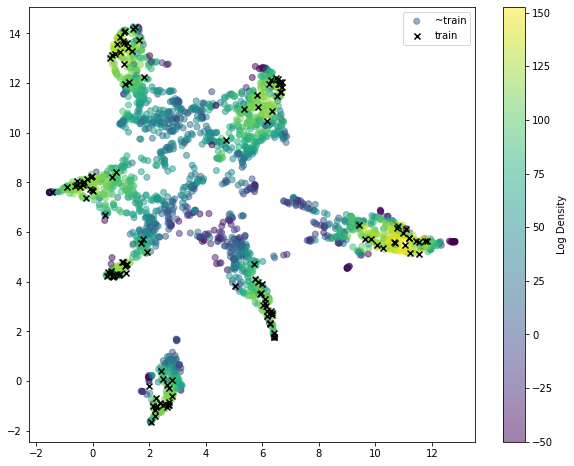

In [52]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model(features)[~mask_train], vmin=-50)
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Log Density')
plt.legend()

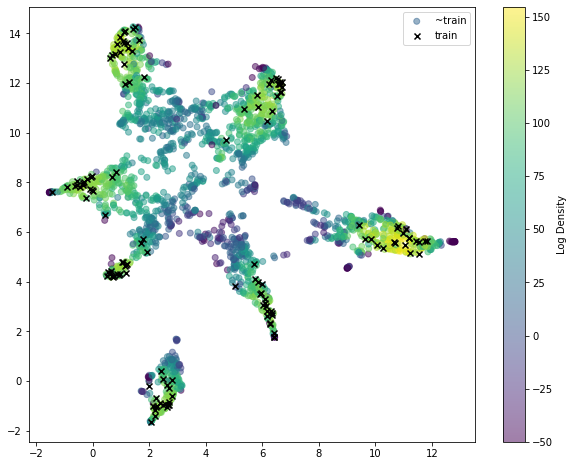

In [53]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_max(features)[~mask_train], vmin=-50)
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Log Density')
plt.legend()

In [55]:
predictions[mask_train].sum(0)

tensor([20., 20., 20., 20., 20., 20., 20.])

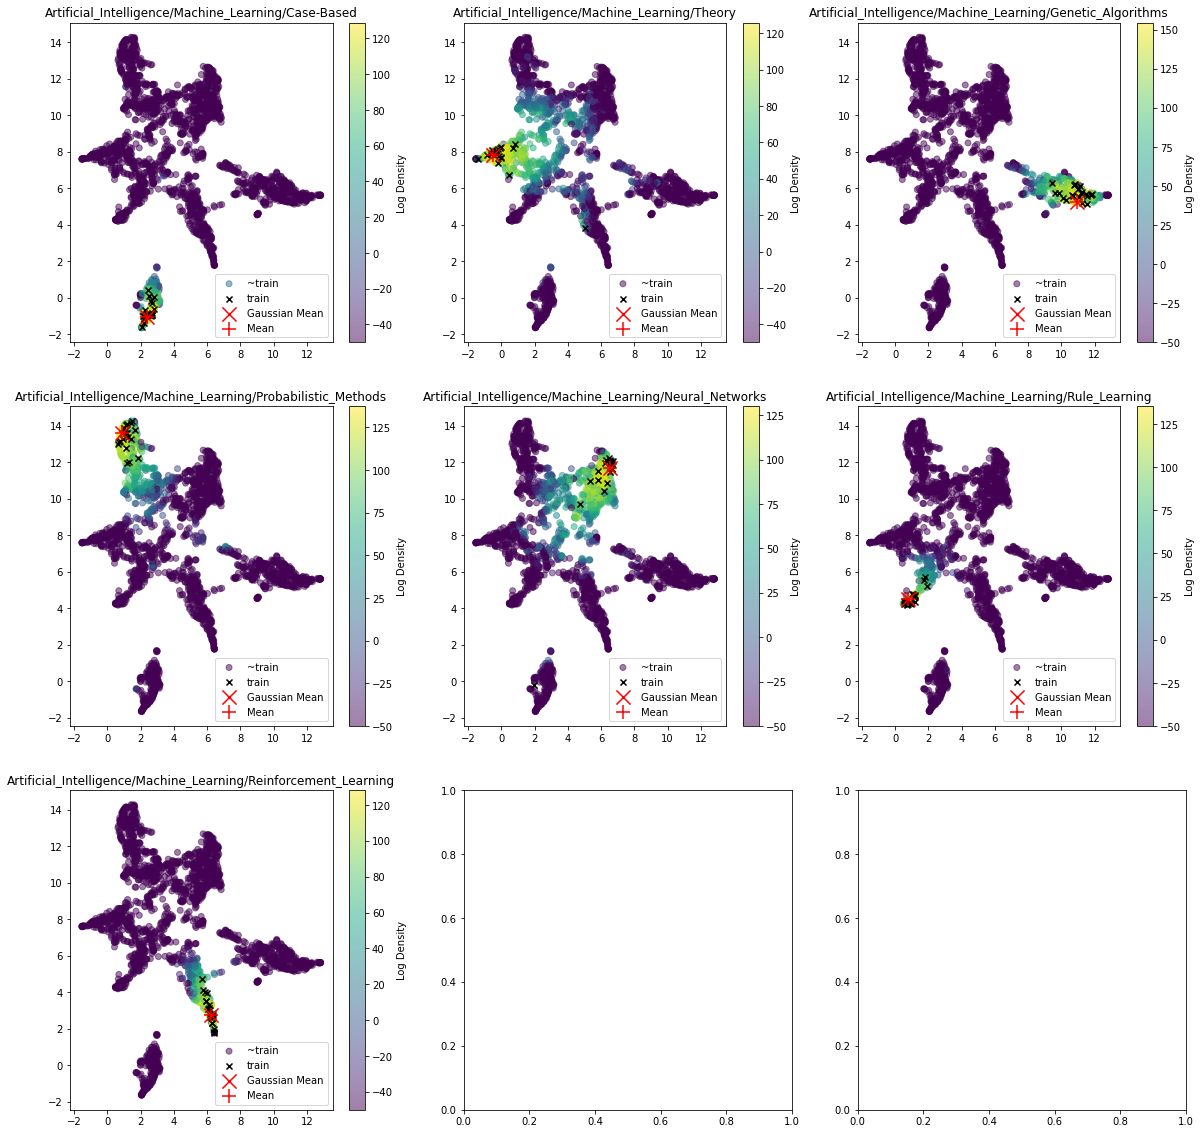

In [57]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model.get_density_class(class_label, features)[~mask_train], vmin=-50)
    ax.scatter(
        features_proj[:, 0][(mask_train) & (labels == class_label)], 
        features_proj[:, 1][(mask_train) & (labels == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    mean_proj = proj.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    real_mean_proj = proj.transform(features[(mask_train) & (labels == class_label)].mean(0, keepdim=True).numpy())
    ax.scatter(real_mean_proj[:, 0], real_mean_proj[:, 1], s=200, marker='+', color='red', label='Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])

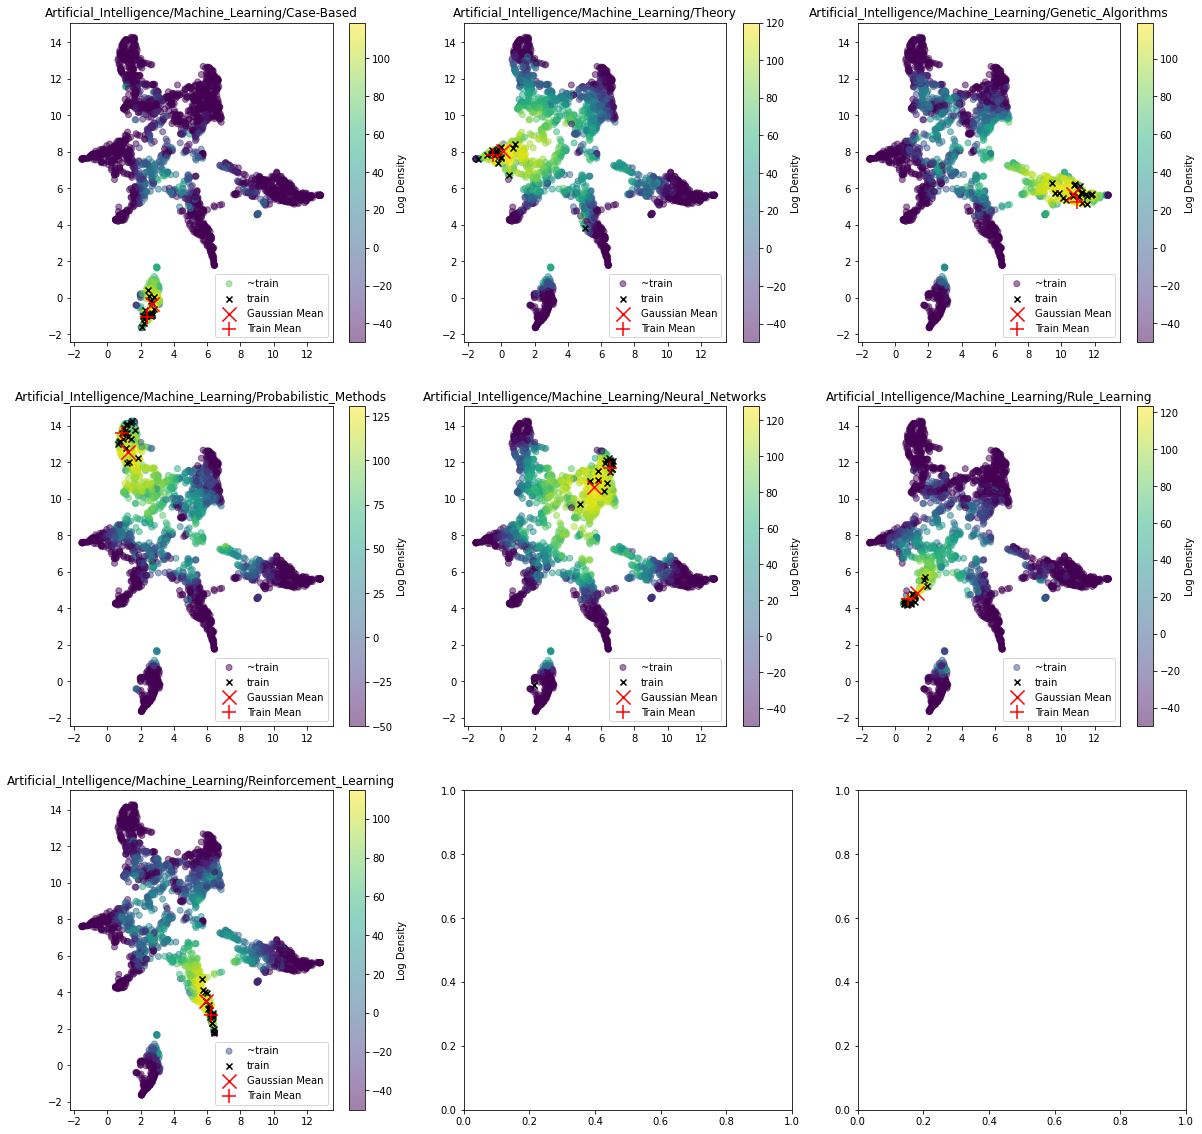

In [59]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_all_graph_best_prediction.get_density_class(class_label, features)[~mask_train], vmin=-50)
    ax.scatter(
        features_proj[:, 0][(mask_train) & (labels == class_label)], 
        features_proj[:, 1][(mask_train) & (labels == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    mean_proj = proj.transform(density_model_all_graph_best_prediction.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    real_mean_proj = proj.transform(features[(mask_train) & (labels == class_label)].mean(0, keepdim=True).numpy())
    ax.scatter(real_mean_proj[:, 0], real_mean_proj[:, 1], s=200, marker='+', color='red', label='Train Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])

In [ ]:
density_model_all_graph_best_prediction_99conf

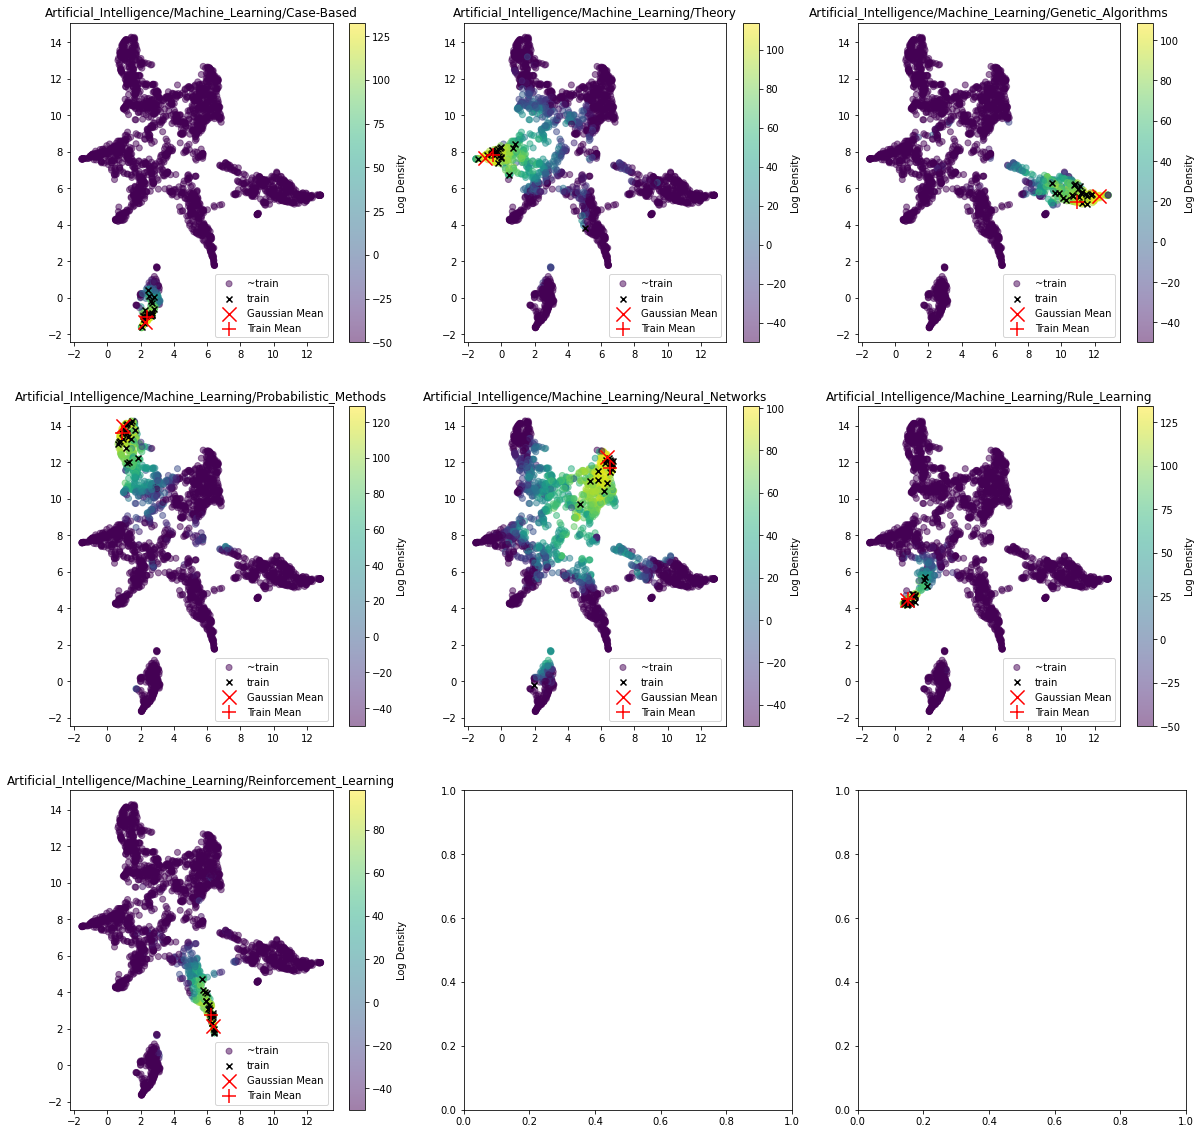

In [61]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_all_graph_best_prediction_99conf.get_density_class(class_label, features)[~mask_train], vmin=-50)
    ax.scatter(
        features_proj[:, 0][(mask_train) & (labels == class_label)], 
        features_proj[:, 1][(mask_train) & (labels == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    mean_proj = proj.transform(density_model_all_graph_best_prediction_99conf.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    real_mean_proj = proj.transform(features[(mask_train) & (labels == class_label)].mean(0, keepdim=True).numpy())
    ax.scatter(real_mean_proj[:, 0], real_mean_proj[:, 1], s=200, marker='+', color='red', label='Train Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])

Text(0, 0.5, 'Max Softmax Score')

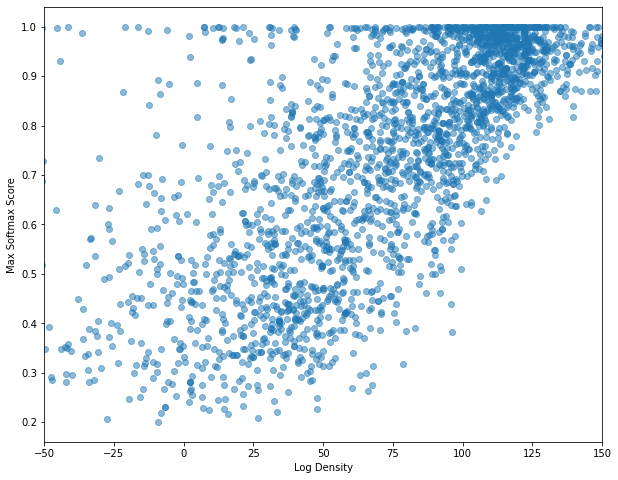

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(
    density_model(features).numpy(),
    predictions.max(1)[0].numpy(),
    alpha = 0.5,
)
ax.set_xlim(left=-50, right=150)
ax.set_xlabel('Log Density')
ax.set_ylabel('Max Softmax Score')


In [74]:
low_epi_high_alea = (density_model(features).numpy() < -50) & (predictions.max(1)[0].numpy() > 0.99)
low_epi_high_alea.sum()

29

In [79]:
idx_to_vertex = {idx : vertex for vertex, idx in data_dict[dconst.TRAIN][0].vertex_to_idx.items()}

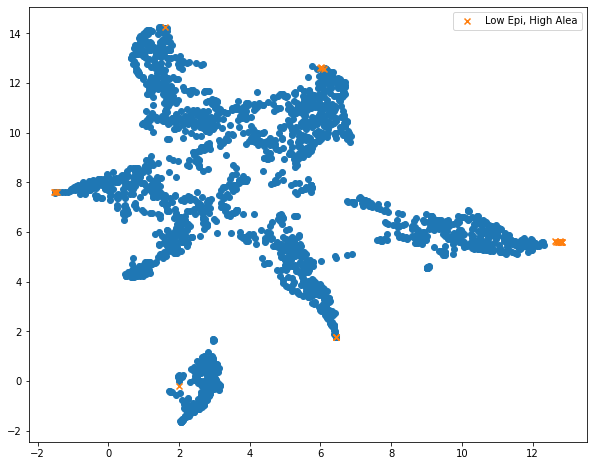

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(features_proj[~low_epi_high_alea][:, 0], features_proj[~low_epi_high_alea][:, 1],)
ax.scatter(features_proj[low_epi_high_alea][:, 0], features_proj[low_epi_high_alea][:, 1], marker='x', label='Low Epi, High Alea')
ax.legend()

In [83]:
vertices_low_epi_high_alea = [idx_to_vertex[v] for v in np.where(low_epi_high_alea)[0]]


In [111]:
vertices_low_epi_high_alea[0]

'6214\n'

In [112]:
vertex_to_idx_full.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [95]:
import data.npz

In [124]:
from tqdm import tqdm

In [125]:
labels_low_epi_high_alea = [idx_to_label[i] for i in labels[low_epi_high_alea].tolist()]
conf_low_epi_high_alea = predictions[low_epi_high_alea].max(1)[0].tolist()

loader = np.load(data.npz.NpzDataset.raw_files[config['data']['dataset']], allow_pickle=True)
vertex_to_idx_full = {v : idx for idx, v in loader['idx_to_node'].item().items()}

text_low_epi_high_alea = [loader['attr_text'][vertex_to_idx_full[i]] for i in tqdm(vertices_low_epi_high_alea)]



100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


In [126]:
for label, conf, text in zip(labels_low_epi_high_alea, conf_low_epi_high_alea, text_low_epi_high_alea):
    print(f'Label {label}, {(conf * 100):.2f} % : {text}')
    

Label Artificial_Intelligence/Machine_Learning/Reinforcement_Learning, 99.89 % : This paper extends previous work with Dyna, a class of architectures for intelligent systems based on approximating dynamic programming methods. Dyna architectures integrate trial-and-error (reinforcement) learning and execution-time planning into a single process operating alternately on the world and on a learned model of the world. In this paper, I present and show results for two Dyna architectures. The Dyna-PI architecture is based on dynamic programming's policy iteration method and can be related to existing AI ideas such as evaluation functions and universal plans (reactive systems). Using a navigation task, results are shown for a simple Dyna-PI system that simultaneously learns by trial and error, learns a world model, and plans optimal routes using the evolving world model. The Dyna-Q architecture is based on Watkins's Q-learning, a new kind of reinforcement learning. Dyna-Q uses a less familiar

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

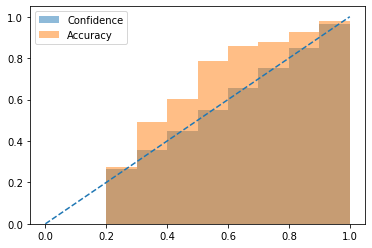

In [128]:


ece = expected_calibration_error(predictions[mask], labels[mask], bins=10, eps=1e-10)
plot_calibration(predictions, labels, bins=10, eps=1e-10)

In [25]:
ece

0.043587625124263264

### Looking at LoC vertices

In [129]:
with torch.no_grad():
    features_ood, predictions_ood, labels_ood, mask_ood_val, logits_ood = [torch.cat(x, 0) for x in run_model_on_datasets(
        model, [data_loaders[dconst.OOD_VAL]], gpus=0, model_kwargs={},
        callbacks = [
            ecbs.make_callback_get_features(mask = False),
            ecbs.make_callback_get_predictions(mask = False),
            ecbs.make_callback_get_ground_truth(mask = False),
            ecbs.make_callback_get_mask(mask = False),
            ecbs.make_callback_get_logits(mask = False),
        ]
    )]
    

In [140]:
vertex_to_idx_ood = data_loaders[dconst.OOD_VAL].dataset[0].vertex_to_idx
idx_to_vertex_ood = {i : v for v, i in vertex_to_idx_ood.items()}
mask_train_ood = torch.zeros(features_ood.size(0)).bool()
for idx_train in torch.where(mask_train)[0].numpy():
    mask_train_ood[vertex_to_idx_ood[idx_to_vertex[idx_train]]] = True



In [157]:
proj_ood = umap.UMAP(random_state = 1337)
proj_ood.fit(features_ood.cpu().numpy())


UMAP(random_state=1337, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [158]:
feature_ood_proj = proj_ood.transform(features_ood.cpu().numpy())

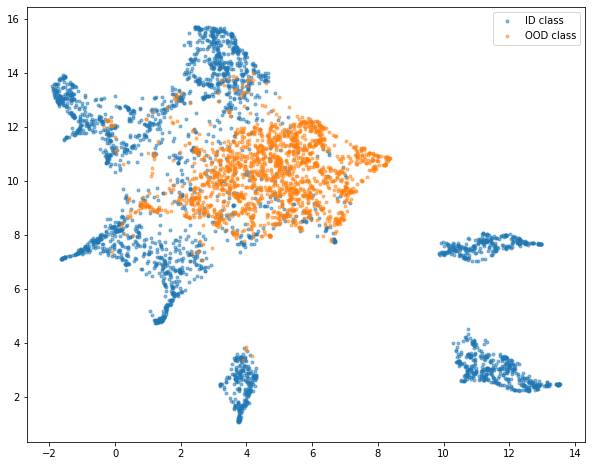

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mask_id_class = labels_ood < predictions_ood.size(1)
ax.scatter(
    feature_ood_proj[mask_id_class][:, 0],
    feature_ood_proj[mask_id_class][:, 1],
    alpha = 0.5,
    label='ID class',
    marker='.'
)
ax.scatter(
    feature_ood_proj[~mask_id_class][:, 0],
    feature_ood_proj[~mask_id_class][:, 1],
    alpha = 0.5,
    label='OOD class',
    marker='.'
)
ax.legend()

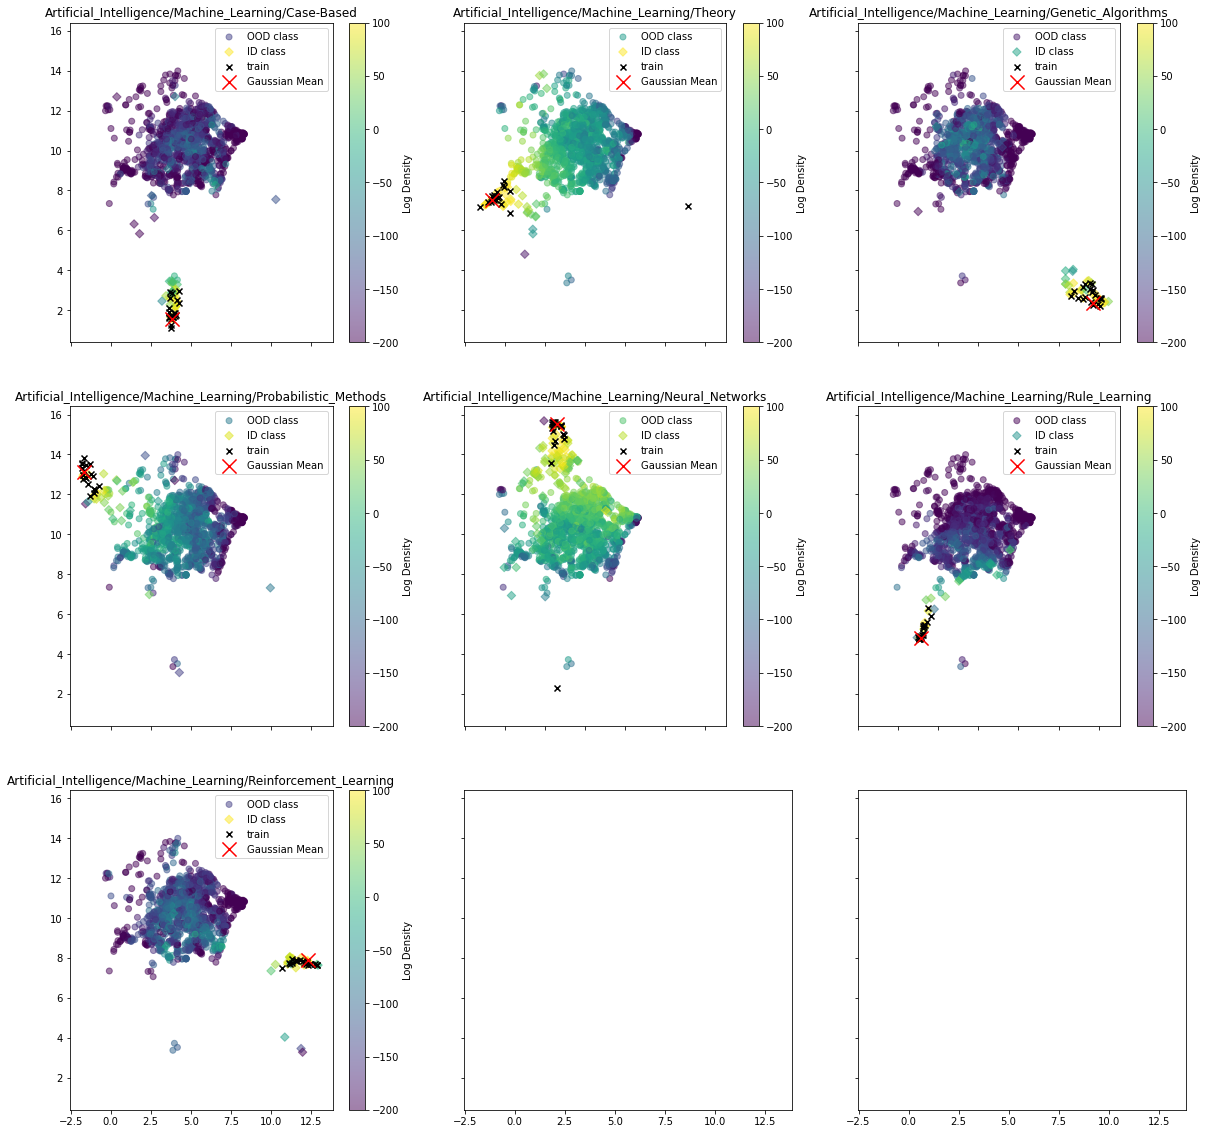

In [212]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(
        feature_ood_proj[:, 0][(~mask_train_ood) & (~mask_id_class) & mask_ood_val], 
        feature_ood_proj[:, 1][(~mask_train_ood) & (~mask_id_class) & mask_ood_val],
        c=density_model.get_density_class(class_label, features_ood)[(~mask_train_ood) & (~mask_id_class) & mask_ood_val],
        alpha = .5, label='OOD class', vmin=-200, vmax=100, marker='o')
    
    h = ax.scatter(
        feature_ood_proj[:, 0][(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val], 
        feature_ood_proj[:, 1][(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val],
        c=density_model.get_density_class(class_label, features_ood)[(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val],
        alpha = .5, label='ID class', vmin=-200, vmax=100, marker='D')
    
    ax.scatter(
        feature_ood_proj[:, 0][(mask_train_ood) & (labels_ood == class_label)], 
        feature_ood_proj[:, 1][(mask_train_ood) & (labels_ood == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    
    mean_proj = proj_ood.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])
    

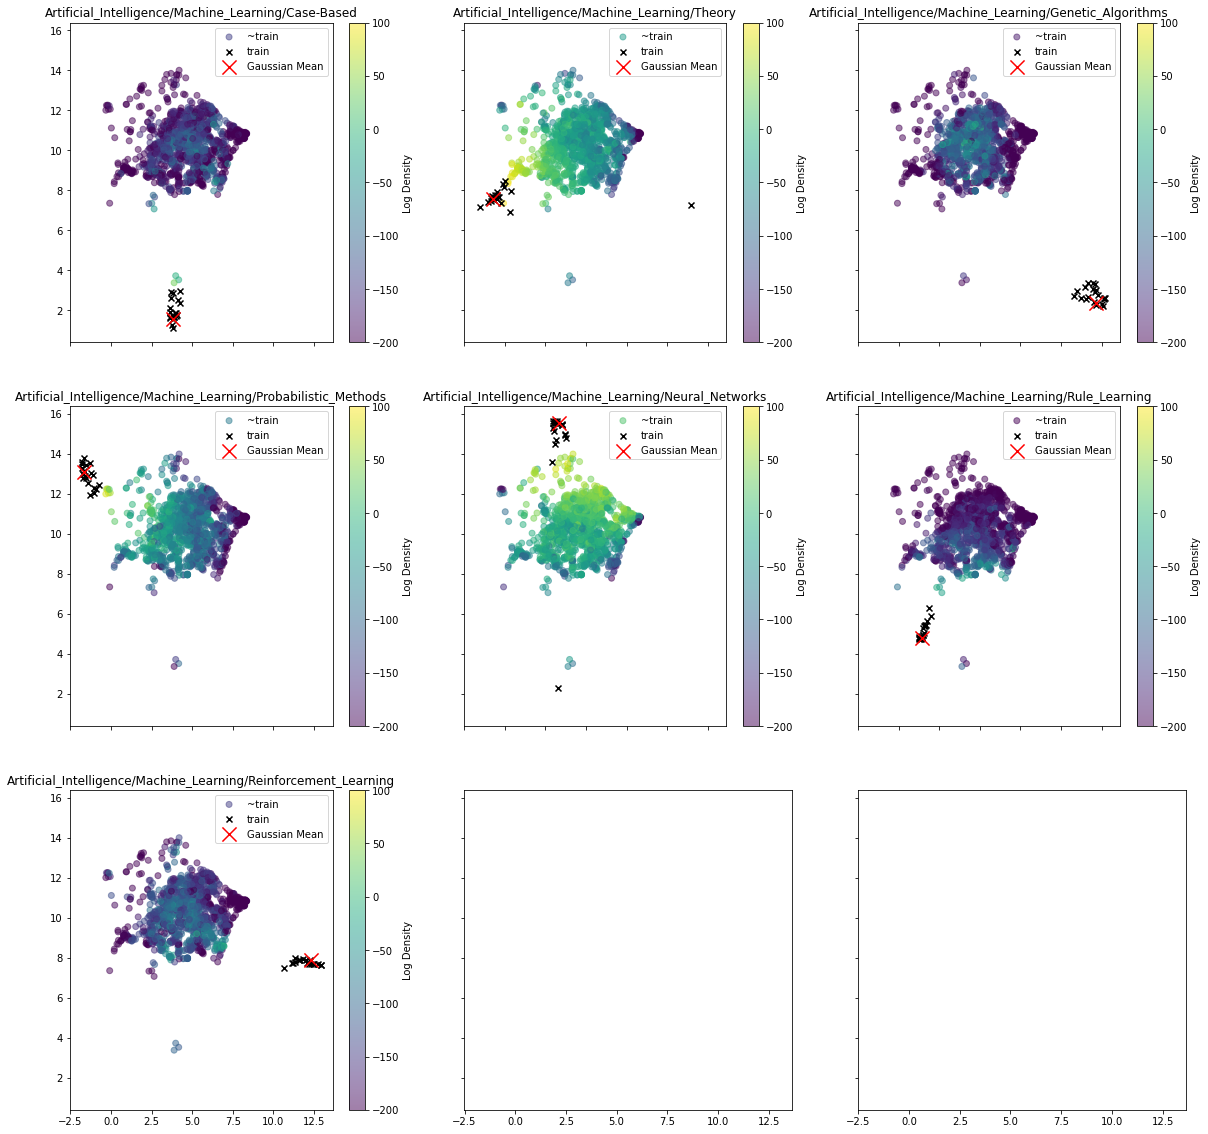

In [213]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(
        feature_ood_proj[:, 0][(~mask_train_ood) & (~mask_id_class) & mask_ood_val], 
        feature_ood_proj[:, 1][(~mask_train_ood) & (~mask_id_class) & mask_ood_val],
        c=density_model.get_density_class(class_label, features_ood)[(~mask_train_ood) & (~mask_id_class) & mask_ood_val],
        alpha = .5, label='~train', vmin=-200, vmax=100)
    ax.scatter(
        feature_ood_proj[:, 0][(mask_train_ood) & (labels_ood == class_label)], 
        feature_ood_proj[:, 1][(mask_train_ood) & (labels_ood == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    
    mean_proj = proj_ood.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])
    

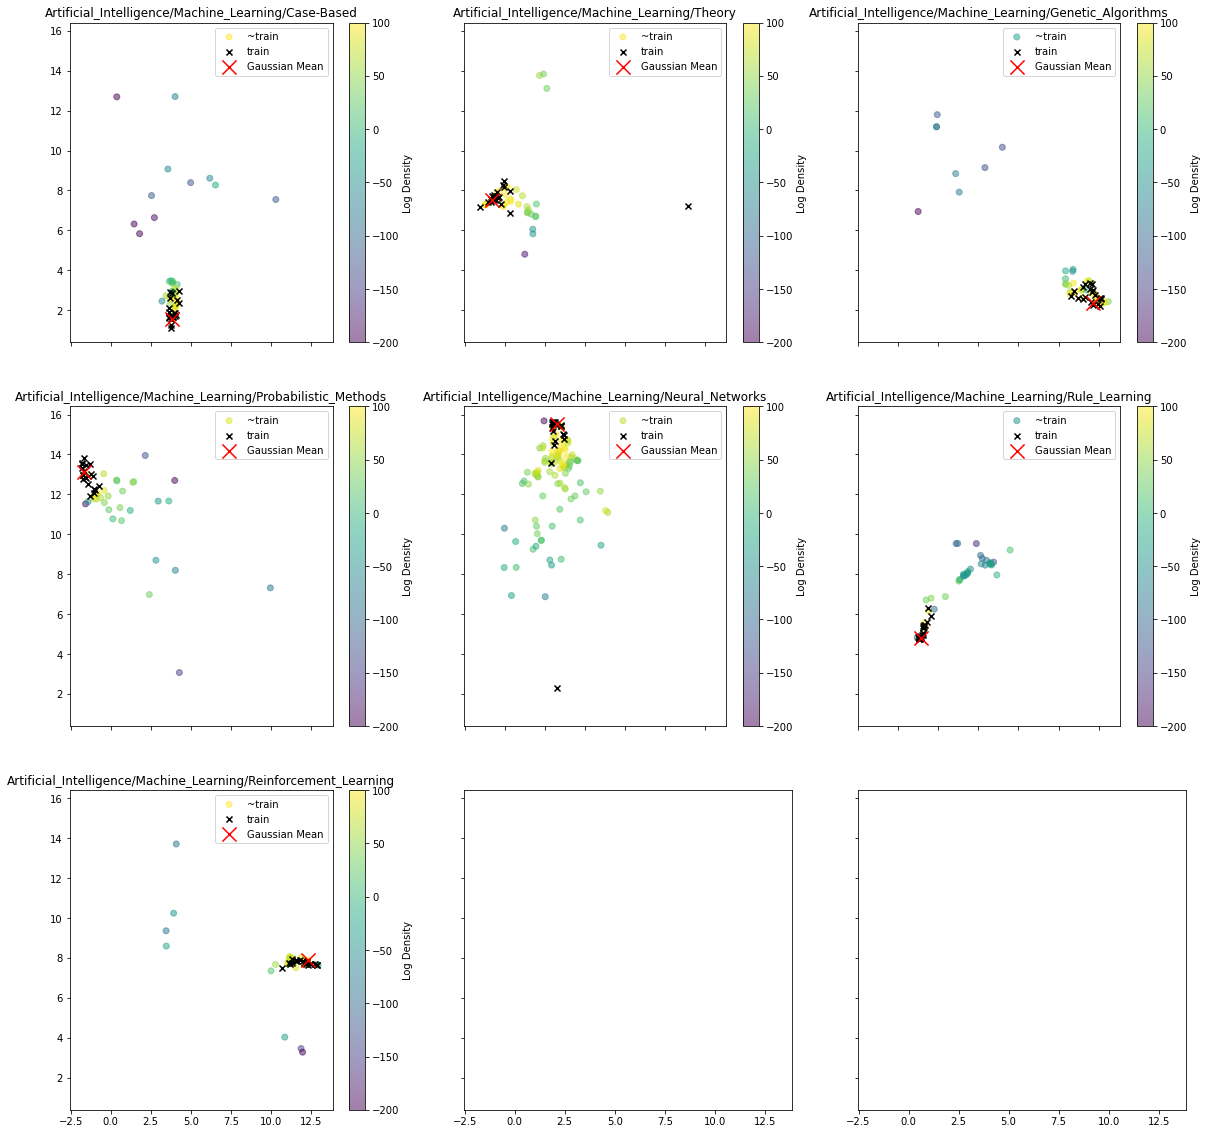

In [214]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(
        feature_ood_proj[:, 0][(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val], 
        feature_ood_proj[:, 1][(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val],
        c=density_model.get_density_class(class_label, features_ood)[(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val],
        alpha = .5, label='~train', vmin=-200, vmax=100)
    ax.scatter(
        feature_ood_proj[:, 0][(mask_train_ood) & (labels_ood == class_label)], 
        feature_ood_proj[:, 1][(mask_train_ood) & (labels_ood == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    
    mean_proj = proj_ood.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])
    

In [193]:
mins, maxs = feature_ood_proj.min(0), feature_ood_proj.max(0)
mins, maxs = mins - 0.1 * (maxs - mins), maxs + 0.05 * (maxs - mins) # Gives a margin for the density map
xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100), np.linspace(mins[1], maxs[1], 100), indexing='ij')
xx, yy = xx.reshape((-1, 1)), yy.reshape((-1, 1))
grid = np.concatenate((xx, yy), axis=-1)
grid_inv = proj_ood.inverse_transform(grid)

In [ ]:
xx, yy, density_grid = xx.reshape((bins_x, bins_y)), yy.reshape((bins_x, bins_y)), density_grid.reshape((bins_x, bins_y))

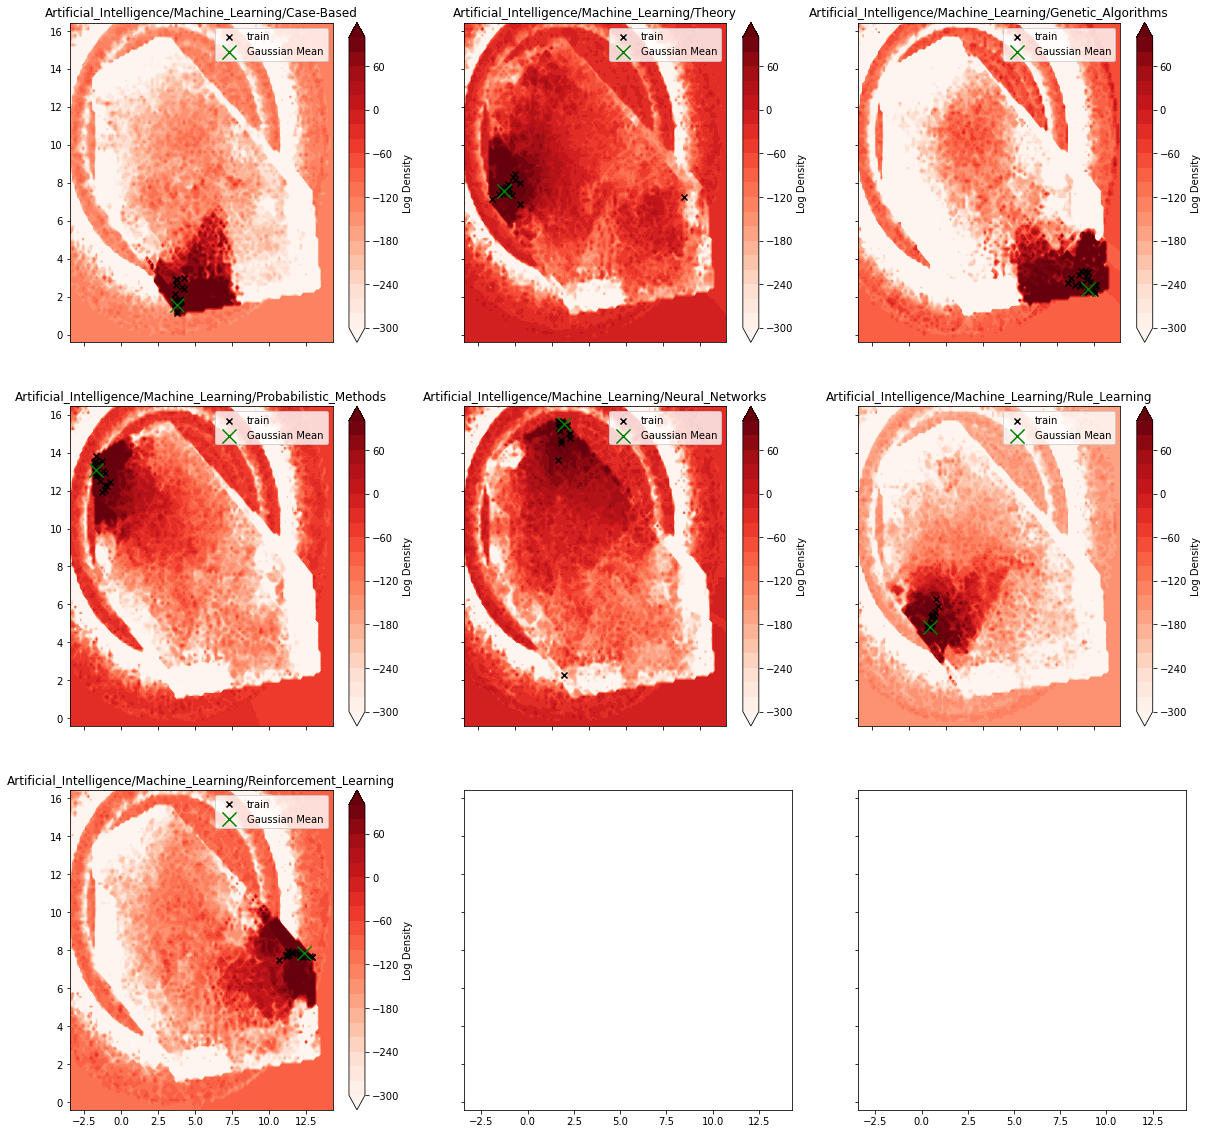

In [207]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

for class_label in (range(predictions.size(1))):
    ax = axs.flatten()[class_label]
    density_grid = density_model.get_density_class(class_label, torch.from_numpy(grid_inv))
    c = ax.contourf(
        xx.reshape((100, 100)), 
        yy.reshape((100, 100)), 
        density_grid.numpy().reshape((100, 100)), cmap='Reds', levels=np.linspace(-300, 100, 21), extend='both')
    ax.scatter(
        feature_ood_proj[:, 0][(mask_train_ood) & (labels_ood == class_label)], 
        feature_ood_proj[:, 1][(mask_train_ood) & (labels_ood == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(c, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    
    mean_proj = proj_ood.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='Green', label='Gaussian Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])


In [197]:
density_grid

tensor([-101.0057, -101.0088, -101.0120,  ...,  -90.8748,  -91.3434,
         -91.3424])

In [ ]:
density_grid = density_model(torch.tensor(proj.inverse_transform(grid)).float()).cpu().numpy()
        xx, yy, density_grid = xx.reshape((bins_x, bins_y)), yy.reshape((bins_x, bins_y)), density_grid.reshape((bins_x, bins_y))

(array([  1.,   0.,   0.,   1.,   0.,   2.,   4.,  18., 108.,   6.]),
 array([-0.3827012 , -0.3390858 , -0.2954704 , -0.251855  , -0.2082396 ,
        -0.1646242 , -0.1210088 , -0.07739341, -0.033778  ,  0.00983739,
         0.05345279], dtype=float32),
 <BarContainer object of 10 artists>)

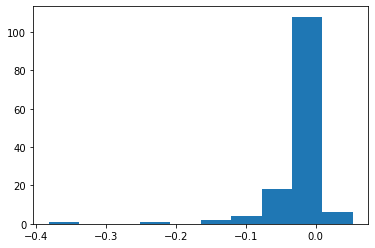

In [156]:
plt.hist((predictions_ood[mask_train_ood].max(1)[0] - predictions_train_orig.max(1)[0][mask_train]).numpy())

In [135]:
[idx_to_vertex[i] for i in  torch.where(mask_train)[0].numpy()]

['1105148\n',
 '1114671\n',
 '18832\n',
 '1104189\n',
 '1120020\n',
 '13967\n',
 '28202\n',
 '28350\n',
 '248823\n',
 '1109957\n',
 '1120170\n',
 '1114629\n',
 '574710\n',
 '1113302\n',
 '83725\n',
 '141342\n',
 '308532\n',
 '33907\n',
 '1153897\n',
 '593328\n',
 '96851\n',
 '578898\n',
 '1116922\n',
 '592986\n',
 '593068\n',
 '96847\n',
 '137873\n',
 '4329\n',
 '159897\n',
 '202522\n',
 '35778\n',
 '94713\n',
 '1108267\n',
 '189712\n',
 '310653\n',
 '1111044\n',
 '683445\n',
 '137130\n',
 '950052\n',
 '1112426\n',
 '1033\n',
 '1136447\n',
 '949318\n',
 '1140289\n',
 '48766\n',
 '815096\n',
 '907845\n',
 '1112059\n',
 '1120049\n',
 '13205\n',
 '151430\n',
 '93279\n',
 '28456\n',
 '10186\n',
 '1108167\n',
 '157257\n',
 '95718\n',
 '1109591\n',
 '1106880\n',
 '61417\n',
 '195150\n',
 '1128856\n',
 '294145\n',
 '372862\n',
 '318187\n',
 '943\n',
 '1104031\n',
 '3095\n',
 '73323\n',
 '15889\n',
 '90219\n',
 '64271\n',
 '272345\n',
 '1103172\n',
 '1105810\n',
 '1111777\n',
 '20821\n',
 '366